In [58]:
import numpy as np
import pandas as pd
import matplotlib

import seaborn as sns

from matplotlib import pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import uncertainties
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import *

import scipy.stats
import random

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x) if abs(x)<0 else ('{:,.2f}'.format(x) if abs(x)<10 else ('{:,.1f}'.format(x) if abs(x)<100 else '{:,.0f}'.format(x))))

path = r"./input/"
outputpath= r"./output/"

#AGWP100_CO2 [mW yr m-2 Tg-1] Source: REF.
agwp100_CO2 = 0.09170

#CH4 tau_strat[yr] Source: REF
tau_strat = 120.0

#CH4 tau_soil [yr] Source: REF
tau_soil = 160.0

#Specific RF for CH4 [mW m-2 ppb-1] Etminan et al., 2016
spec_rf_ch4 = 0.44300





In [155]:
#uncertainty_matrix = [unc_h2_burden,unc_h2_drydep,unc_h2_atmloss,
#                      unc_h2_atmprod,unc_h2_estemis,unc_ch4_burden,unc_ch4_loss]
uncertainty_matrix = np.array([[1,0,0,0,0,0,0],
                               [0,1,0,0,0,0,0],
                               [0,0,1,0,0,0,0],
                               [0,0,0,1,0,0,0],
                               [0,0,0,0,1,0,0],
                               [0,0,0,0,0,1,0],
                               [0,0,0,0,0,0,1],
                               [1,1,1,1,1,1,1]], dtype=bool)
uncertainty_matrix

array([[ True, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False],
       [False, False,  True, False, False, False, False],
       [False, False, False,  True, False, False, False],
       [False, False, False, False,  True, False, False],
       [False, False, False, False, False,  True, False],
       [False, False, False, False, False, False,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

In [221]:
tot_gwp = pd.DataFrame()
df_drydep = pd.DataFrame()
df_lifetime = pd.DataFrame()
compiled_gwp = pd.DataFrame()

for rc in range(8):
    unc_h2_burden = uncertainty_matrix[rc][0]
    unc_h2_drydep = uncertainty_matrix[rc][1]
    unc_h2_atmloss = uncertainty_matrix[rc][2]
    unc_h2_atmprod = uncertainty_matrix[rc][3]
    unc_h2_estemis = uncertainty_matrix[rc][4]
    unc_ch4_burden = uncertainty_matrix[rc][5]
    unc_ch4_loss = uncertainty_matrix[rc][6]
    
    for i in range(1000):
        
            file = 'H2_burden.txt'
            df_h2_burden = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            delta = df_h2_burden.loc['10H2']-df_h2_burden.loc['CTRL']
            delta.name = 'deltaH2'
            df_h2_burden = df_h2_burden.append(delta)
            df_h2_burden
            if(unc_h2_burden):
                df_b = pd.DataFrame()
                lower = df_h2_burden.loc['CTRL'].min()
                upper = df_h2_burden.loc['CTRL'].max()
                mu, sigma = df_h2_burden['OSLOCTM3'].loc['CTRL'], df_h2_burden.loc['CTRL'].std() #mean and standard deviation
                sampleCTRL = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
                adjust = sampleCTRL/df_h2_burden['OSLOCTM3'].loc['CTRL']
                df_h2_burden = df_h2_burden*adjust
                df_b = pd.concat([df_b,df_h2_burden])

            #print(df_h2_burden)

            file = 'H2_drydep.txt'
            df_h2_drydep = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            df_h2_drydep
            if(unc_h2_drydep):
                #print('NB drydep adjusted')
                #Adjust by the relative adjustment in the control simulations
                drydep = np.random.normal(70, 10)
                outputpath = outputpath + 'drydep_'+ f'{drydep:.0f}_'
                adjust = drydep/df_h2_drydep.loc['CTRL']
                df_h2_drydep = df_h2_drydep*adjust
                #print(df_h2_drydep)

            file = 'H2_atm_loss.txt'
            df_h2_atmloss = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            if(unc_h2_atmloss):
                lower = df_h2_atmloss.loc['CTRL'].min()
                upper = df_h2_atmloss.loc['CTRL'].max()
                mu, sigma = df_h2_atmloss.loc['CTRL'].mean(), df_h2_atmloss.loc['CTRL'].std() #mean and standard deviation
                sampleCTRL = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
                        #sampleCTRL = np.random.normal(mu, sigma)
                adjust = sampleCTRL/df_h2_atmloss.loc['CTRL']
                df_h2_atmloss = df_h2_atmloss*adjust
            df_h2_atmloss

            df_h2_loss = df_h2_atmloss + df_h2_drydep
            df_h2_loss

            file = 'H2_atm_prod.txt'
            df_h2_atmprod = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            df_ap = pd.DataFrame()
            
            if(unc_h2_atmprod):
                lower = df_h2_atmprod.loc['CTRL'].min()
                upper = df_h2_atmprod.loc['CTRL'].max()
                mu, sigma = df_h2_atmprod['OSLOCTM3'].loc['CTRL'], df_h2_atmprod.loc['CTRL'].std() #mean and standard deviation
                sampleCTRL = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
                adjust = sampleCTRL/df_h2_atmprod['OSLOCTM3'].loc['CTRL']
                df_h2_atmprod = df_h2_atmprod*adjust
                df_ap = pd.concat([df_ap,df_h2_atmprod])
            #print(df_h2_atmprod)

            df_h2_estemis = df_h2_atmloss.loc['CTRL'] + df_h2_drydep.loc['CTRL'] - df_h2_atmprod.loc['CTRL']
            df_h2_estemis
            df_ee = pd.DataFrame()
            if(unc_h2_estemis):
                lower = df_h2_estemis.min()
                upper = df_h2_estemis.max()
                mu, sigma = df_h2_estemis['OSLOCTM3'], df_h2_estemis.std() #mean and standard deviation
                sampleCTRL = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
                adjust = sampleCTRL/df_h2_estemis['OSLOCTM3']
                df_h2_estemis = df_h2_estemis*adjust
                df_ee = pd.concat([df_ee,df_h2_estemis])
            #print(df_h2_estemis)

            file = 'H2_surfconc.txt'
            df_h2_surfconc = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            delta = df_h2_surfconc.loc['10H2']-df_h2_surfconc.loc['CTRL']
            delta.name = 'deltaH2'
            df_h2_surfconc = df_h2_surfconc.append(delta)
            df_h2_surfconc

            df_h2_lifetime = df_h2_burden.drop('deltaH2')/df_h2_loss
            df_h2_lifetime

            df_h2_atm_lifetime = df_h2_burden.drop('deltaH2')/df_h2_atmloss
            df_h2_atm_lifetime

            df_h2_flux = df_h2_burden.drop('deltaH2')/df_h2_lifetime
            #Add delta flux 10H2:
            delta = df_h2_flux.loc['10H2']-df_h2_flux.loc['CTRL']
            delta.name = 'deltaH2'
            df_h2_flux = df_h2_flux.append(delta)
            #Add delta flux 10CH4:
            delta = df_h2_flux.loc['10CH4']-df_h2_flux.loc['CTRL']
            delta.name = 'deltaCH4'
            df_h2_flux = df_h2_flux.append(delta)
            df_h2_flux

            file = 'CH4_burden.txt'
            df_ch4_burden = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            delta = df_ch4_burden.loc['10CH4']-df_ch4_burden.loc['CTRL']
            delta.name = 'deltaCH4'
            df_ch4_burden = df_ch4_burden.append(delta)
            df_ch4_burden
            df_cb = pd.DataFrame()
            if(unc_ch4_burden):
                lower = df_ch4_burden.loc['CTRL'].min()
                upper = df_ch4_burden.loc['CTRL'].max()
                mu, sigma = df_ch4_burden['OSLOCTM3'].loc['CTRL'], df_ch4_burden.loc['CTRL'].std() #mean and standard deviation
                sampleCTRL = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
                adjust = sampleCTRL/df_ch4_burden['OSLOCTM3'].loc['CTRL']
                df_ch4_burden = df_ch4_burden*adjust
                df_cb = pd.concat([df_cb,df_ch4_burden])
            #print(df_ch4_burden)

            file = 'CH4_loss.txt'
            df_ch4_loss = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            #adjust_ch4_loss = False
            df_cl = pd.DataFrame()
            if(unc_ch4_loss):
                lower = df_ch4_loss.loc['CTRL'].min()
                upper = df_ch4_loss.loc['CTRL'].max()
                mu, sigma = df_ch4_loss['OSLOCTM3'].loc['CTRL'], df_ch4_loss.loc['CTRL'].std() #mean and standard deviation
                sampleCTRL = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
                adjust = sampleCTRL/df_ch4_loss['OSLOCTM3'].loc['CTRL']
                df_ch4_loss = df_ch4_loss*adjust
                df_cl = pd.concat([df_cl,df_ch4_loss])
            #print(df_ch4_loss)

            file = 'CH4_surfconc.txt'
            df_ch4_surfconc = pd.read_csv(path + file, sep=';',index_col=0,header=0)
            delta = df_ch4_surfconc.loc['10CH4']-df_ch4_surfconc.loc['CTRL']
            delta.name = 'deltaCH4'
            df_ch4_surfconc = df_ch4_surfconc.append(delta)

            df_ch4_lifetime = df_ch4_burden.drop('deltaCH4')/df_ch4_loss

            df_ch4_tot_lifetime = 1.0/(1.0/df_ch4_lifetime + 1.0/tau_strat + 1.0/tau_soil)

            df_ch4_flux = df_ch4_burden.drop('deltaCH4')/df_ch4_tot_lifetime

            #Add delta CH4 flux 10H2
            delta = df_ch4_flux.loc['10H2']-df_ch4_flux.loc['CTRL']
            delta.name = 'deltaH2'
            df_ch4_flux = df_ch4_flux.append(delta)
            #Add delta CH4 flux 10CH4
            delta = df_ch4_flux.loc['10CH4']-df_ch4_flux.loc['CTRL']
            delta.name = 'deltaCH4'
            df_ch4_flux = df_ch4_flux.append(delta)

            file = 'ozone_du_trop.txt'
            df_ozone_du_trop = pd.read_csv(path+file, sep=';',index_col=0,header=0)
            file = 'ozone_du_strat.txt'
            df_ozone_du_strat = pd.read_csv(path+file, sep=';',index_col=0,header=0)
            file = 'ozone_rf.txt'
            df_ozone_rf = pd.read_csv(path+file, sep=';',index_col=0,header=0)
            df_ozone_rf['OSLOCTM3-emi'].loc['10CH4'] = df_ozone_rf['OSLOCTM3'].loc['10CH4'] 

            file = 'H2O_rf.txt'
            df_h2o_rf = pd.read_csv(path+file, sep=';',index_col=0,header=0)
            df_h2o_rf['OSLOCTM3-emi'].loc['10CH4'] = df_h2o_rf['OSLOCTM3'].loc['10CH4'] 
            file = 'H2O_rf_gfdl.txt'
            h2o_rf_gfdl = pd.read_csv(path + file, sep=',',index_col=0,header=0)

            df_surf_h2_per_h2_flux = df_h2_surfconc.loc['deltaH2']/df_h2_flux.loc['deltaH2']
            df_surf_h2_per_h2_flux.name = 'surf_h2_per_h2_flux'

            df_ch4_flux_per_h2_flux = -1.0*df_ch4_flux.loc['deltaH2']/df_h2_flux.loc['deltaH2']
            df_ch4_flux_per_h2_flux.name = 'ch4_flux_per_h2_flux'

            df_surf_ch4_per_ch4_flux =  df_ch4_surfconc.loc['deltaCH4']/df_ch4_flux.loc['deltaCH4']
            df_surf_ch4_per_ch4_flux.name = 'surf_ch4_per_ch4_flux'
            df_surf_ch4_per_ch4_flux['OSLOCTM3-emi'] = df_surf_ch4_per_ch4_flux['OSLOCTM3']

            df_surf_ch4_per_h2_flux = df_surf_ch4_per_ch4_flux*df_ch4_flux_per_h2_flux
            df_surf_ch4_per_h2_flux.name = 'surf_ch4_per_h2_flux'
            #Add GFDL:
            #Increase in surface concentration CH4:
            #1808 to 2005 ppbv (REF Paolot)
            df_surf_ch4_per_h2_flux['GFDL-emi']= (2005.-1808.)/df_h2_flux['GFDL-emi'].loc['deltaH2']

            df_h2_flux_per_ch4_flux = -1.0*df_h2_flux.loc['deltaCH4']/df_ch4_flux.loc['deltaCH4']
            df_h2_flux_per_ch4_flux.name = 'h2_flux_per_ch4_flux'
            df_h2_flux_per_ch4_flux['OSLOCTM3-emi'] = df_h2_flux_per_ch4_flux['OSLOCTM3']

            df_h2_agwp_ch4 = df_surf_ch4_per_h2_flux*spec_rf_ch4
            df_h2_agwp_ch4.name = 'h2_agwp_ch4'


            #agwp_ch4 = RF per flux H2 (For the per flux table)
            df_ch4_rf_per_h2_flux = df_surf_ch4_per_h2_flux*spec_rf_ch4
            df_ch4_rf_per_h2_flux.name = 'ch4_rf_per_h2_flux'

            antmod = len(df_h2_agwp_ch4.index)
            df_h2_gwp = pd.DataFrame(np.empty([5,antmod])*np.nan,columns=df_h2_agwp_ch4.index,
                                     index=['O3','CH4','strat H2O','O3 CH4ind','strat H2O CH4ind'])

            df_h2_gwp.loc['CH4'] = df_h2_agwp_ch4/agwp100_CO2

            df_h2_agwp_h2o = df_h2o_rf.loc['10H2']/df_h2_flux.loc['deltaH2']
            df_h2_agwp_h2o['GFDL-emi'] = h2o_rf_gfdl['GFDL'].loc['H2+CH4 [mW m-2]']/df_h2_flux['GFDL-emi'].loc['deltaH2']
            df_h2_agwp_h2o.name = 'h2_agwp_h2o'

            #NBNB GFDL methane induced is included.

            #Add to the flux table
            df_h2o_rf_per_h2_flux = df_h2o_rf.loc['10H2']/df_h2_flux.loc['deltaH2']
            df_h2o_rf_per_h2_flux.name= 'h2o_rf_per_h2_flux'
            df_h2o_rf_per_h2_flux['GFDL-emi'] = h2o_rf_gfdl['GFDL'].loc['H2 [mW m-2]']/df_h2_flux['GFDL-emi'].loc['deltaH2']

            #Strat H2O RF per methane flux (Move this to the methane part?)
            df_h2o_rf_per_ch4_flux = df_h2o_rf.loc['10CH4']/df_ch4_flux.loc['deltaCH4']
            df_h2o_rf_per_ch4_flux.name = 'h2o_rf_per_ch4_flux'
            df_h2o_rf_per_ch4_flux['OSLOCTM3-emi'] = df_h2o_rf_per_ch4_flux['OSLOCTM3']

            df_h2_gwp.loc['strat H2O'] = df_h2_agwp_h2o/agwp100_CO2

            df_h2_agwp_o3 = df_ozone_rf.loc['10H2']/df_h2_flux.loc['deltaH2']
            df_h2_agwp_o3.name = 'h2_agwp_o3'
            #For GFDL-emi include the methane induced part.
            df_h2_agwp_o3['GFDL-emi'] = (df_ozone_rf['GFDL-emi'].loc['10H2']+df_ozone_rf['GFDL-emi'].loc['10CH4'])/df_h2_flux['GFDL-emi'].loc['deltaH2']

            #Similar, but use only the H2 Ozone RF for GFDL. To be used in the table:
            df_ozone_rf_per_h2_flux = df_ozone_rf.loc['10H2']/df_h2_flux.loc['deltaH2']
            df_ozone_rf_per_h2_flux.name= 'ozone_rf_per_h2_flux'

            #Ozone RF per methane flux (move to the methane part?)
            df_ozone_rf_per_ch4_flux = df_ozone_rf.loc['10CH4']/df_ch4_flux.loc['deltaCH4']
            df_ozone_rf_per_ch4_flux.name = 'ozone_rf_per_ch4_flux'

            df_ozone_rf_per_ch4_flux['OSLOCTM3-emi'] = df_ozone_rf_per_ch4_flux['OSLOCTM3']

            df_h2_gwp.loc['O3'] = df_h2_agwp_o3/agwp100_CO2

            df_trop_du_ozone_per_ch4_flux = df_ozone_du_trop.loc['10CH4']/df_ch4_flux.loc['deltaCH4']
            df_trop_du_ozone_per_ch4_flux.name = 'trop_du_ozone_per_ch4_flux'

            df_strat_du_ozone_per_ch4_flux = df_ozone_du_strat.loc['10CH4']/df_ch4_flux.loc['deltaCH4']
            df_strat_du_ozone_per_ch4_flux.name = 'strat_du_ozone_per_ch4_flux'

            df_trop_du_ozone_per_h2_flux = df_ozone_du_trop.loc['10H2']/df_h2_flux.loc['deltaH2']
            df_trop_du_ozone_per_h2_flux.name = 'trop_du_ozone_per_h2_flux'

            df_strat_du_ozone_per_h2_flux = df_ozone_du_strat.loc['10H2']/df_h2_flux.loc['deltaH2']
            df_strat_du_ozone_per_h2_flux.name = 'strat_du_ozone_per_h2_flux'

            df_trop_du_ozone_per_ch4_flux['OSLOCTM3-emi']=df_trop_du_ozone_per_ch4_flux['OSLOCTM3']
            df_strat_du_ozone_per_ch4_flux['OSLOCTM3-emi']=df_strat_du_ozone_per_ch4_flux['OSLOCTM3']
            df_ch4_surfconc['OSLOCTM3-emi'].loc['deltaCH4']=df_ch4_surfconc['OSLOCTM3'].loc['deltaCH4']

            #Wm-2/ppbCH4*ppbCH4/TgH2yr-1 -> Wm-2/TgH2yr-1
            df_h2_agwp_ch4ind_o3 = df_ozone_rf.loc['10CH4']/df_ch4_surfconc.loc['deltaCH4']*df_surf_ch4_per_h2_flux
            df_h2_agwp_ch4ind_o3.name = 'h2_agwp_ch4ind_o3'

            df_h2_gwp.loc['O3 CH4ind'] = df_h2_agwp_ch4ind_o3/agwp100_CO2

            df_h2_agwp_ch4ind_h2o = df_h2o_rf.loc['10CH4']/df_ch4_surfconc.loc['deltaCH4']*df_surf_ch4_per_h2_flux
            df_h2_agwp_ch4ind_h2o.name = 'h2_agwp_ch4ind_h2o'

            df_h2_gwp.loc['strat H2O CH4ind'] = df_h2_agwp_ch4ind_h2o/agwp100_CO2

            #Methane GWP
            antmod = len(df_h2_agwp_ch4.index)
            df_ch4_gwp = pd.DataFrame(np.empty([4,antmod])*np.nan,columns=df_h2_agwp_ch4.index,
                                     index=['O3','CH4','strat H2O','H2'])

            df_ch4_agwp_o3 = df_ozone_rf.loc['10CH4']/df_ch4_surfconc.loc['deltaCH4']*df_surf_ch4_per_ch4_flux
            df_ch4_agwp_o3.name = 'ch4_agwp_o3'

            df_ch4_gwp.loc['O3'] =df_ch4_agwp_o3/agwp100_CO2 

            df_ch4_agwp =df_surf_ch4_per_ch4_flux*spec_rf_ch4
            df_ch4_agwp.name = 'ch4_agwp'

            #Add Methane GWP:
            df_ch4_gwp.loc['CH4'] =df_ch4_agwp/agwp100_CO2 

            #print(df_h2o_rf.loc['10CH4'])
            df_ch4_agwp_h2o = df_h2o_rf.loc['10CH4']/df_ch4_surfconc.loc['deltaCH4']*df_surf_ch4_per_ch4_flux
            df_ch4_agwp_h2o.name = 'ch4_agwp_h2o'

            df_ch4_gwp.loc['strat H2O'] = df_ch4_agwp_h2o/agwp100_CO2

            df_ch4_gwp.loc['H2'] = df_h2_flux_per_ch4_flux*df_h2_gwp.sum()

            model_dict = { 'OSLOCTM3':'OsloCTM',
                           'WACCM6-2deg':'WACCM',
                           'INCA':'INCA',
                           'GFDL-emi':'GFDL-emi',
                           'GFDL_nudge':'GFDL',
                           'UKCA':'UKCA',
                           'OSLOCTM3-emi':'OsloCTM-emi'}

            sorted_array = ['GFDL','OsloCTM','INCA','UKCA','WACCM','GFDL-emi','OsloCTM-emi']

            #Save to file below. Where CH4 are split based on feedback factor:
            #print(outputpath + 'table_h2_gwp.csv')
            #df_h2_gwp.to_csv(outputpath + 'table_h2_gwp.csv')
            #df_h2_gwp = df_h2_gwp[sorted(df_h2_gwp.columns)]

            df_h2_gwp = df_h2_gwp[sorted(df_h2_gwp.columns)]

            df_h2_gwp.loc['total']=df_h2_gwp.sum()

            df_h2_gwp_table = df_h2_gwp.copy()

            df_h2_gwp_table.rename(model_dict,axis=1,inplace=True)
            df_h2_gwp_table = df_h2_gwp_table[sorted_array]
            df_h2_gwp_table.T

            compiled_gwp = pd.concat([compiled_gwp,df_h2_gwp])
            tot_gwp = pd.concat([tot_gwp,df_h2_gwp_table.loc['total']])
            df_drydep = pd.concat([df_drydep, df_h2_drydep])
            df_lifetime = pd.concat([df_lifetime, df_h2_lifetime])
print("Done")
ct_gwp = compiled_gwp.transpose()

print(compiled_gwp.loc['total'])

Done
       GFDL-emi  GFDL_nudge  INCA  OSLOCTM3  OSLOCTM3-emi  UKCA  WACCM6-2deg
total      11.7        9.74  9.35      12.8          12.3  6.78         11.2
total      11.7        9.74  9.35      12.8          12.3  6.78         11.2
total      11.7        9.74  9.35      12.8          12.3  6.78         11.2
total      11.7        9.74  9.35      12.8          12.3  6.78         11.2
total      11.7        9.74  9.35      12.8          12.3  6.78         11.2
...         ...         ...   ...       ...           ...   ...          ...
total      8.09        6.85  6.25      10.1          9.68  7.00         10.3
total      10.4        8.81  8.03      13.0          12.5  8.99         13.2
total      10.4        8.88  8.09      13.1          12.5  9.06         13.3
total      8.44        7.03  6.42      10.4          9.96  7.18         10.5
total      7.54        6.51  5.93      9.56          9.16  6.64         9.71

[8000 rows x 7 columns]


In [223]:

O3_df = pd.DataFrame()
lv = 4000
hv = 5000
print(compiled_gwp['OSLOCTM3'].loc['O3'][lv:hv].describe())
print(compiled_gwp['OSLOCTM3'].loc['CH4'][lv:hv].describe())
print(compiled_gwp['OSLOCTM3'].loc['strat H2O'][lv:hv].describe())
print(compiled_gwp['OSLOCTM3'].loc['O3 CH4ind'][lv:hv].describe())
print(compiled_gwp['OSLOCTM3'].loc['strat H2O CH4ind'][lv:hv].describe())
print(compiled_gwp['OSLOCTM3'].loc['total'][lv:hv].describe())

#print(compiled_gwp.loc['O3'][1000:2000].describe())
#print(compiled_gwp.loc['O3'][2000:3000].describe())


#print(compiled_gwp.loc['total'][3000:4000].describe())
#print(compiled_gwp.loc['total'][4000:5000].describe())
#print(compiled_gwp.loc['total'][5000:6000].describe())
#print(compiled_gwp.loc['total'][6000:7000].describe())
#print(compiled_gwp.loc['total'][7000:8000].describe())



count   1,000
mean     2.38
std      0.00
min      2.38
25%      2.38
50%      2.38
75%      2.38
max      2.38
Name: OSLOCTM3, dtype: float64
count   1,000
mean     5.22
std      0.00
min      5.22
25%      5.22
50%      5.22
75%      5.22
max      5.22
Name: OSLOCTM3, dtype: float64
count   1,000
mean     1.89
std      0.00
min      1.89
25%      1.89
50%      1.89
75%      1.89
max      1.89
Name: OSLOCTM3, dtype: float64
count   1,000
mean     2.67
std      0.00
min      2.67
25%      2.67
50%      2.67
75%      2.67
max      2.67
Name: OSLOCTM3, dtype: float64
count   1,000
mean     0.66
std      0.00
min      0.66
25%      0.66
50%      0.66
75%      0.66
max      0.66
Name: OSLOCTM3, dtype: float64
count   1,000
mean     12.8
std      0.00
min      12.8
25%      12.8
50%      12.8
75%      12.8
max      12.8
Name: OSLOCTM3, dtype: float64


In [228]:
lv = 7000
hv = 8000
print(compiled_gwp.loc['O3'][lv:hv].describe())
print(compiled_gwp.loc['CH4'][lv:hv].describe())
print(compiled_gwp.loc['strat H2O'][lv:hv].describe())
print(compiled_gwp.loc['O3 CH4ind'][lv:hv].describe())
print(compiled_gwp.loc['strat H2O CH4ind'][lv:hv].describe())
print(compiled_gwp.loc['total'][lv:hv].describe())



       GFDL-emi  GFDL_nudge  INCA  OSLOCTM3  OSLOCTM3-emi  UKCA  WACCM6-2deg
count     1,000       1,000 1,000     1,000         1,000 1,000        1,000
mean       3.23        1.90  1.26      2.21          2.28  1.43         2.08
std        0.40        0.23  0.15      0.26          0.27  0.17         0.25
min        2.34        1.39  0.92      1.61          1.66  1.05         1.52
25%        2.94        1.73  1.15      2.02          2.08  1.31         1.89
50%        3.18        1.87  1.24      2.18          2.24  1.41         2.04
75%        3.45        2.02  1.34      2.35          2.43  1.53         2.21
max        4.86        2.80  1.86      3.26          3.38  2.11         3.06
       GFDL-emi  GFDL_nudge  INCA  OSLOCTM3  OSLOCTM3-emi  UKCA  WACCM6-2deg
count     1,000       1,000 1,000     1,000         1,000 1,000        1,000
mean       3.93        4.33  4.07      4.81          4.94  5.12         5.90
std        0.49        0.52  0.49      0.58          0.60  0.61         0.71

In [84]:
print(df_h2_gwp_uhb)
#print(df_h2_gwp_uhd)
#print(df_h2_gwp_uhal)
uhb = ['Burden','Burden','Burden','Burden','Burden','Burden','Burden']
uhd = ['DryDep','DryDep','DryDep','DryDep','DryDep','DryDep','DryDep']
uhal = ['AtmLoss','AtmLoss','AtmLoss','AtmLoss','AtmLoss','AtmLoss','AtmLoss']
comb = ['UHComb','UHComb','UHComb','UHComb','UHComb','UHComb','UHComb']

uhb = [1,1,1,1,1,1,1]
uhd = [2,2,2,2,2,2,2]
uhal = [3,3,3,3,3,3,3]
comb = [4,4,4,4,4,4,4]


df_h2_gwp_uhb_test = df_h2_gwp_uhb.transpose()
df_h2_gwp_uhd_test = df_h2_gwp_uhd.transpose()
df_h2_gwp_comb_test = df_h2_gwp_combined.transpose()

df_h2_gwp_uhb_test['UNC'] = uhb
df_h2_gwp_uhd_test['UNC'] = uhd
df_h2_gwp_comb_test['UNC'] = comb

#df_h2_gwp_uhd['UNC'] = uhd
#df_h2_gwp_uhal['UNC'] = uhal
print(df_h2_gwp_uhb_test)
print(df_h2_gwp_uhd_test)


                  GFDL-emi  GFDL_nudge  INCA  OSLOCTM3  OSLOCTM3-emi  UKCA  \
O3                    3.98        2.29  1.60      2.38          2.45  1.18   
CH4                   4.84        5.27  5.22      5.22          5.35  4.24   
strat H2O             2.87         NaN  0.81      1.89          1.06   NaN   
O3 CH4ind              NaN        2.19  1.43      2.67          2.73  1.36   
strat H2O CH4ind       NaN         NaN  0.30      0.66          0.67   NaN   
total                 11.7        9.74  9.35      12.8          12.3  6.78   

                  WACCM6-2deg  
O3                       1.92  
CH4                      5.50  
strat H2O                0.56  
O3 CH4ind                2.93  
strat H2O CH4ind         0.26  
total                    11.2  
               O3  CH4  strat H2O  O3 CH4ind  strat H2O CH4ind  total  UNC
GFDL-emi     3.98 4.84       2.87        NaN               NaN   11.7    1
GFDL_nudge   2.29 5.27        NaN       2.19               NaN   9.74    1
INCA

           O3  CH4  strat H2O  O3 CH4ind  strat H2O CH4ind  total  UNC
OSLOCTM3 2.38 5.22       1.89       2.67              0.66   12.8    1
OSLOCTM3 2.18 4.79       1.73       2.45              0.60   11.8    2
OSLOCTM3 2.49 5.46       1.98       2.79              0.69   13.4    4


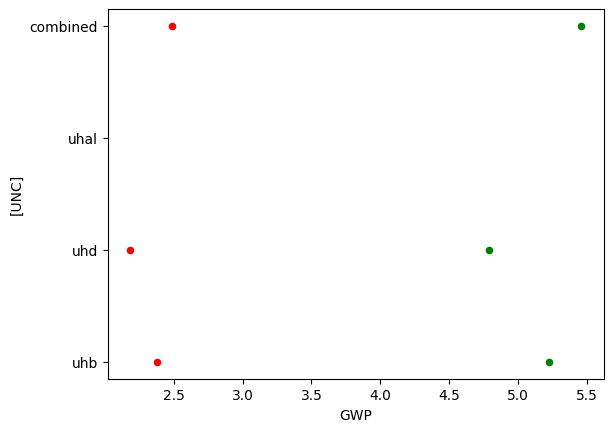

In [134]:
df_h2_plot = pd.DataFrame()
df_h2_plot = df_h2_gwp_uhb_test
df_h2_plot = pd.concat([df_h2_plot, df_h2_gwp_uhd_test])
df_h2_plot = pd.concat([df_h2_plot, df_h2_gwp_comb_test])
print(df_h2_plot.loc['OSLOCTM3'])

labels = ['uhb','uhd','uhal','combined']
yt = [1,2,3,4]
ax1 = df_h2_plot.loc['OSLOCTM3'].plot(kind='scatter', x=['O3'], y=['UNC'], color='r')    
ax2 = df_h2_plot.loc['OSLOCTM3'].plot(kind='scatter', x=['CH4'], y=['UNC'], color='g', ax=ax1)   
ax1.set_xlabel("GWP")
ax1.set_xlabel("GWP")
plt.yticks(x, labels, rotation='vertical')

#ax3 = df.plot(kind='scatter', x='e', y='f', color='b', ax=ax1)

#df_h2_plot.loc['OSLOCTM3'].plot(ax=axes[['O3'],['UNC']])
#df_h2_plot.loc['OSLOCTM3'].plot(ax=axes['CH4','UNC'])
plt.show()
#df_h2_plot.loc['OSLOCTM3'].plot(['O3','CH4'],['UNC','UNC'],kind='scatter')

In [ ]:
    if(unc_h2_burden):
        ax = df_b.loc['CTRL'].plot.hist(bins=25, color='Blue', title='CTRL', legend=False)
    if(unc_h2_atmprod):
        ax = df_ap.loc['CTRL'].plot.hist(bins=25, color='Blue', title='CTRL', legend=False)
    if(unc_h2_estemis):
        ax = df_ee.loc['CTRL'].plot.hist(bins=25, color='Blue', title='CTRL', legend=False)
    if(unc_ch4_burden):
        ax = df_cb.loc['CTRL'].plot.hist(bins=25, color='Blue', title='CTRL', legend=False)
    if(unc_ch4_loss):
        ax = df_cl.loc['CTRL'].plot.hist(bins=25, color='Blue', title='CTRL', legend=False)


In [ ]:
df_h2_gwp_table.T

In [ ]:
df_h2_gwp['OSLOCTM3']
yr = ['7','6','5','4','3','2','1']
print(df_h2_gwp)

In [ ]:
#ax = tot_gwp.loc['GFDL'].plot.hist(bins=25, title='GFDL')
#ax2 = tot_gwp.loc['INCA'].plot.hist(bins=25, title='INCA')
#ax3 = tot_gwp.loc['OsloCTM'].plot.hist(bins=25, title='OsloCTM')
ax4 = df_drydep.loc['CTRL'].plot.hist(bins=25, color='Blue', title='DryDep CTRL', legend=False)
ax4 = df_lifetime.loc['CTRL'].plot.hist(bins=25, color='Blue', title='Atm Lifetime CTRL', legend=False)



In [ ]:
fig, ax = plt.subplots()

sns.distplot(tot_gwp.loc['GFDL'], hist=False, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label='GFDL', ax=ax)
sns.distplot(tot_gwp.loc['INCA'], hist=False, kde=True, 
             bins=100, color = 'tomato', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label='INCA', ax=ax)
sns.distplot(tot_gwp.loc['OsloCTM'], hist=False, kde=True, 
             bins=100, color = 'Red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label='OsloCTM', ax=ax)

sns.distplot(tot_gwp.loc['UKCA'], hist=False, kde=True, 
             bins=100, color = 'olive', 
             hist_kws={'edgecolor':'brown'},
             kde_kws={'linewidth': 2}, label='UKCA', ax=ax)
sns.distplot(tot_gwp.loc['WACCM'], hist=False, kde=True, 
             bins=100, color = 'Purple', 
             hist_kws={'edgecolor':'cyan'},
             kde_kws={'linewidth': 2}, label='WACCM', ax=ax)
sns.distplot(tot_gwp.loc['GFDL-emi'], hist=False, kde=True, 
             bins=100, color = 'Orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label='GFDL-emi', ax=ax)
sns.distplot(tot_gwp.loc['OsloCTM-emi'], hist=False, kde=True, 
             bins=100, color = 'Pink', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label='OsloCTM-emi', ax=ax)
plt.xlabel('Total GWP') 
plt.legend()
ax.scatter([9.68],[0.6])
p1 = [7.94,0.6]
p2 = [11.3, 0.6]
plt.plot([p1[0],p2[0]], [p1[1],p2[1]])
plt.show()

In [ ]:
print(tot_gwp.describe())
tot_gwp.loc['GFDL-emi'].describe()
#sns.distplot(mean_gwp, hist=False, kde=True, 
#             bins=100, color = 'black', 
#             hist_kws={'edgecolor':'black'},
#             kde_kws={'linewidth': 2}, ax=ax)


In [ ]:
plt.scatter([9.69],[1.5])
p1 = [8.08,1.5]
p2 = [11.1, 1.5]
plt.plot([p1[0],p2[0]], [p1[1],p2[1]])

plt.scatter([10.6],[1])
p1 = [9.02,1]
p2 = [12.06, 1]
plt.plot([p1[0],p2[0]], [p1[1],p2[1]])

plt.scatter([11.3],[0.8])
p1 = [11.1,0.8]
p2 = [11.5, 0.8]
plt.plot([p1[0],p2[0]], [p1[1],p2[1]])

plt.scatter([9.68],[0.5])
p1 = [7.94,0.5]
p2 = [11.3, 0.5]
plt.plot([p1[0],p2[0]], [p1[1],p2[1]])

plt.xlabel('Total GWP') 

plt.show()